In [3]:
from __future__ import annotations
import typing
from dataclasses import dataclass, field
import warnings
from contextlib import contextmanager
import itertools

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
@contextmanager
def localize_globals(*exceptions: str, restore_values: bool = True):
    exceptions: typing.Set[str] = set(exceptions)

    old_globals: typing.Dict[str, typing.Any] = dict(globals())
    allowed: typing.Set[str] = set(old_globals.keys())
    allowed.update(exceptions)

    yield None

    new_globals: typing.Dict[str, typing.Any] = globals()

    for name in tuple(new_globals.keys()):
        if name not in allowed:
            del new_globals[name]
    
    if not restore_values:
        return
    
    new_globals.update(
        {k: v for k, v in old_globals.items() if k not in exceptions}
    )

In [6]:
# To please the linter a bit.
# Not actually meant to represent types, but rather array shapes.
N = typing.TypeVar("N")
M = typing.TypeVar("M")

In [39]:
def chebyshev_nodes(
    n: int,
    a: float,
    b: float,
) -> np.ndarray['N']:
    center: float = (a + b) / 2
    radius: float = (b - a) / 2
    
    return center + radius * np.cos(np.pi * (2 * np.arange(n) + 1) / (2 * n))


In [55]:
def chebyshev_interpolate(
    f: typing.Callable[[np.ndarray], np.ndarray],
    n: int,
    a: float,
    b: float,
) -> np.ndarray['N']:
    """
    Returns the coefficients of the interpolating polynomial
    on the Chebyshev nodes of the function f.
    The coefficients are in the order of decreasing powers
    """
    
    nodes: np.ndarray['N'] = chebyshev_nodes(n, a, b)
    values: np.ndarray['N'] = f(nodes)
    
    result: np.ndarray['N'] = np.zeros(n, dtype="float64")
    
    for i in range(n):
        L_i: np.ndarray['N'] = np.poly(nodes[np.arange(n) != i])
        L_i /= np.polyval(L_i, nodes[i])
        
        result += values[i] * L_i
    
    return result


In [9]:
def differentiate_poly(
    coeffs: np.ndarray['N'],
) -> np.ndarray['N-1']:
    """
    Returns the coefficients of the derivative of a polynomial
    """
    
    return coeffs[:-1] * np.arange(len(coeffs) - 1, 0, -1)


In [10]:
def chebyshev_derivatives(
    f: typing.Callable[[np.ndarray], np.ndarray],
    n: int,
    a: float,
    b: float,
) -> np.ndarray['N']:
    """
    Returns the approximate values of the derivatives of f
    in the Chebyshev nodes of the interval [a, b]
    """
    
    coeffs: np.ndarray['N-1'] = differentiate_poly(chebyshev_interpolate(f, n, a, b))
    nodes: np.ndarray['N'] = chebyshev_nodes(n, a, b)
    
    return np.polyval(coeffs, nodes)


In [37]:
def test_accuracy(
    f: typing.Callable[[np.ndarray], np.ndarray],
    df: typing.Callable[[np.ndarray], np.ndarray],
    a: float,
    b: float,
    n_range: typing.Iterable[int] = np.arange(2, 50),
    name: str = "Derivative absolute error",
    ax: typing.Optional[plt.Axes] = None,
) -> None:
    errors: list[float] = []
    
    for n in n_range:
        ders: np.ndarray['N'] = chebyshev_derivatives(f, n, a, b)
        true_ders: np.ndarray['N'] = df(chebyshev_nodes(n, a, b))
        
        errors.append(np.max(np.abs(ders - true_ders)))
    
    errors: np.ndarray['N'] = np.array(errors)
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    fig: plt.Figure
    ax: plt.Axes
    
    ax.set_title(name)
    ax.set_xlabel("n")
    ax.set_ylabel("error")
    
    ax.set_yscale("log")
    
    ax.plot(n_range, errors, label="absolute error")
    
    ax.legend()
    

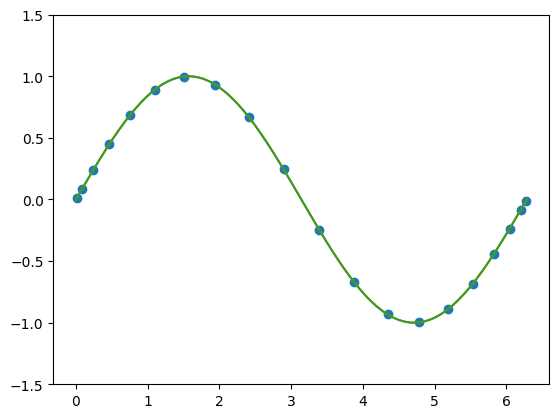

[ 1.00381978  1.00107602  0.97439618  0.89703777  0.73101274  0.45275011
  0.0708185  -0.36029307 -0.74285657 -0.96980159 -0.96975258 -0.74292891
 -0.36025544  0.07060528  0.45246233  0.72982209  0.89476362  0.97151309
  0.99628134  0.99981727]
[ 0.99995311  0.99623503  0.97154216  0.89474138  0.72984109  0.45244481
  0.07062249 -0.36027331 -0.74290928 -0.96977569 -0.96977569 -0.74290928
 -0.36027331  0.07062249  0.45244481  0.72984109  0.89474138  0.97154216
  0.99623503  0.99995311]


In [63]:
with localize_globals():
    f = np.sin
    df = np.cos
    n = 20
    
    segment: tuple[float, float] = (0, 2 * np.pi)
    
    grid: np.ndarray['N'] = np.linspace(*segment, 1000)
    
    plt.figure()
    plt.ylim(-1.5, 1.5)
    plt.plot(chebyshev_nodes(n, *segment), f(chebyshev_nodes(n, *segment)), "o")
    plt.plot(grid, f(grid))
    plt.plot(grid, np.polyval(chebyshev_interpolate(f, n, *segment), grid))
    plt.show()
    
    print(chebyshev_derivatives(f, n, 0, 2 * np.pi))
    print(df(chebyshev_nodes(n, 0, 2 * np.pi)))

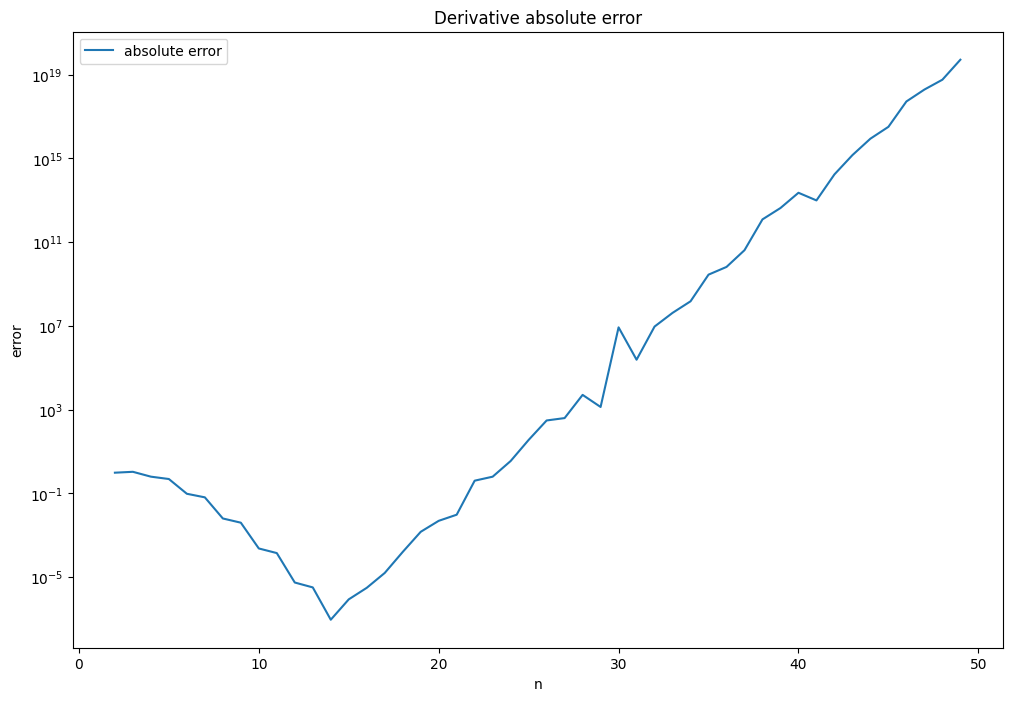

In [64]:
with localize_globals():
    fig, ax = plt.subplots(figsize=(12, 8))
    
    test_accuracy(np.sin, np.cos, 0, 2 * np.pi, ax=ax)
